## Time Series Analysis with ARIMA

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime, date

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [46]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [6]:
df = pd.read_pickle("indego_df_model.pkl")

In [8]:
df_time = df[['start_time', 'duration']].sort_values('start_time').copy()
df_time.set_index(pd.DatetimeIndex(df_time['start_time']), drop=True, inplace=True)
df_time.drop('start_time', axis='columns', inplace=True)

In [154]:
d1 = date(2017, 7, 1)
d2 = date(2017, 8, 31)
condi_day = (df_time.index.date>=d1)&(df_time.index.date<=d2)

In [160]:
df_test = df_time[condi_day].copy()

In [162]:
ts = pd.Series(df_test['duration'], index=df_test.index)

In [163]:
ts[1:5]

start_time
2017-07-01 00:06:00    15.0
2017-07-01 00:06:00    31.0
2017-07-01 00:06:00    15.0
2017-07-01 00:07:00    30.0
Name: duration, dtype: float64

In [184]:
df_halfhour = ts.resample('30Min').mean()

In [185]:
df_halfhour.head(5)

start_time
2017-07-01 00:00:00    17.363636
2017-07-01 00:30:00    24.481481
2017-07-01 01:00:00    12.714286
2017-07-01 01:30:00     9.692308
2017-07-01 02:00:00     7.200000
Freq: 30T, Name: duration, dtype: float64

In [188]:
df_halfhour.fillna(0, inplace=True)

In [189]:
df_halfhour.index

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:30:00',
               '2017-07-01 01:00:00', '2017-07-01 01:30:00',
               '2017-07-01 02:00:00', '2017-07-01 02:30:00',
               '2017-07-01 03:00:00', '2017-07-01 03:30:00',
               '2017-07-01 04:00:00', '2017-07-01 04:30:00',
               ...
               '2017-08-31 19:00:00', '2017-08-31 19:30:00',
               '2017-08-31 20:00:00', '2017-08-31 20:30:00',
               '2017-08-31 21:00:00', '2017-08-31 21:30:00',
               '2017-08-31 22:00:00', '2017-08-31 22:30:00',
               '2017-08-31 23:00:00', '2017-08-31 23:30:00'],
              dtype='datetime64[ns]', name='start_time', length=2976, freq='30T')

<IPython.core.display.Javascript object>


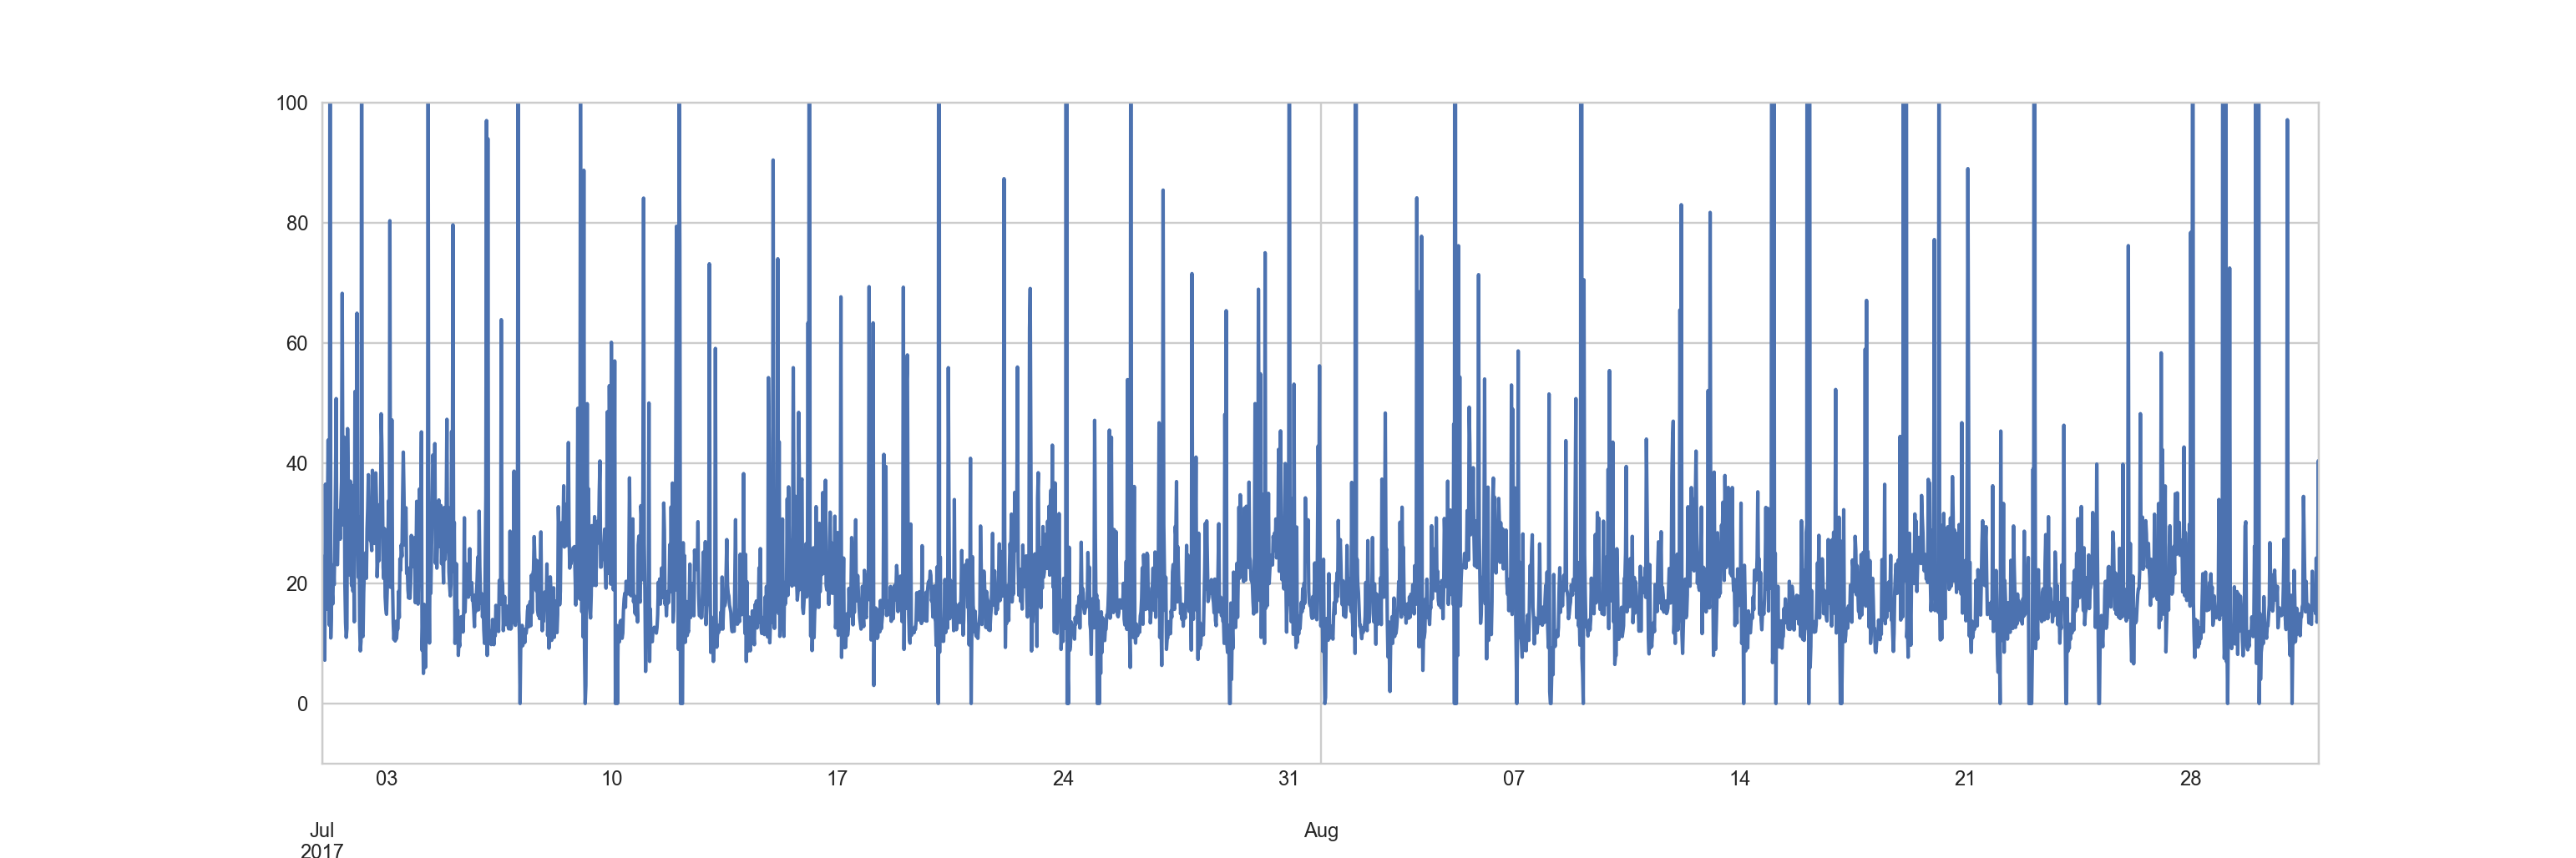

In [266]:
f0, ax0 = plt.subplots(figsize=(18, 6))
df_halfhour.plot(ylim=[-10,100])

In [191]:
ts_diff = df_halfhour - df_halfhour.shift()
ts_diff.dropna(inplace=True)

In [265]:
ts_diff.plot()

In [173]:
lag_acf = acf(ts_diff, nlags=20)

In [174]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

<IPython.core.display.Javascript object>


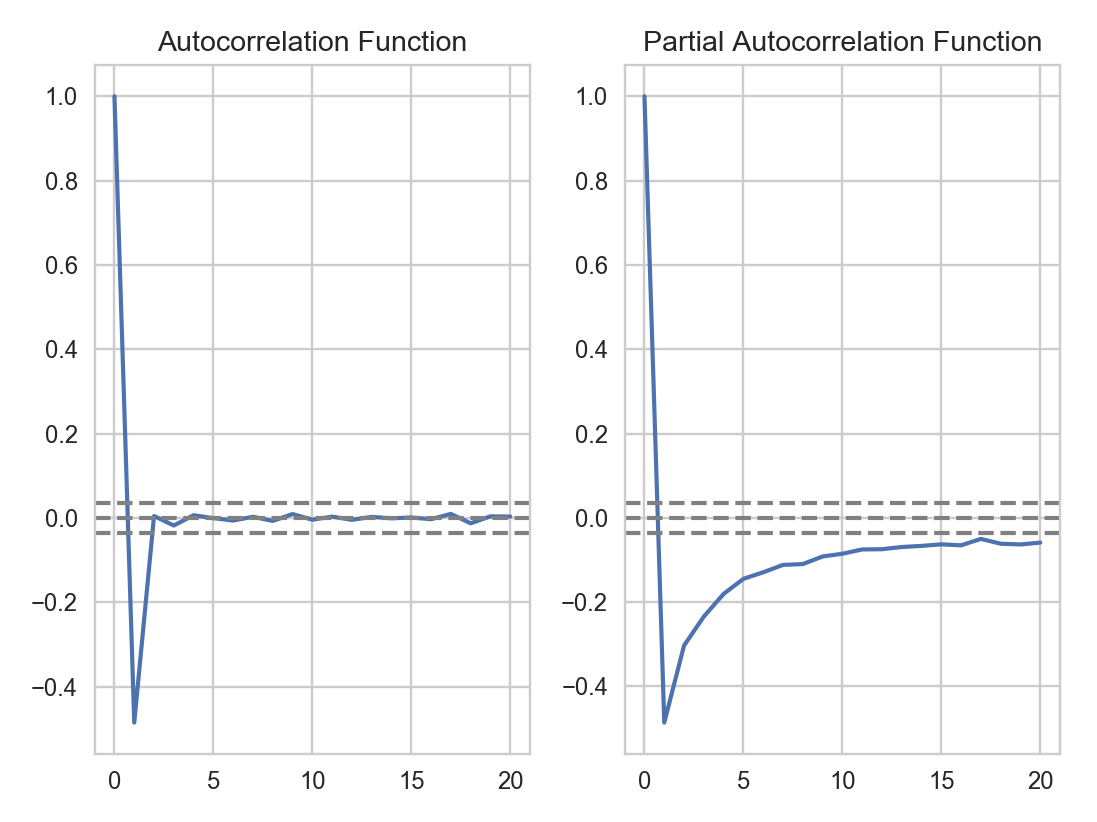

In [204]:
#Plot ACF:
fig1 = plt.figure()
fig1.add_subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
fig1.add_subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.


#### Grid search

In [257]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [259]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_halfhour,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:30312.84550697684
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:29981.7561358718
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:31126.871969925454
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:28976.847110043884
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:29902.34805230217
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:29105.11242097431
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:30121.244117817074
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:28978.5034857902
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:30059.704334278267
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:29816.87116937717
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:31113.598914557726
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:28966.654489706107
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:29800.50842057464
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:29090.3939737236
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:30120.182179453484
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:28968.329519249637
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:31094.80585467787
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:30959.369958417847
ARIM

In [232]:
model = ARIMA(df_halfhour, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  

<IPython.core.display.Javascript object>


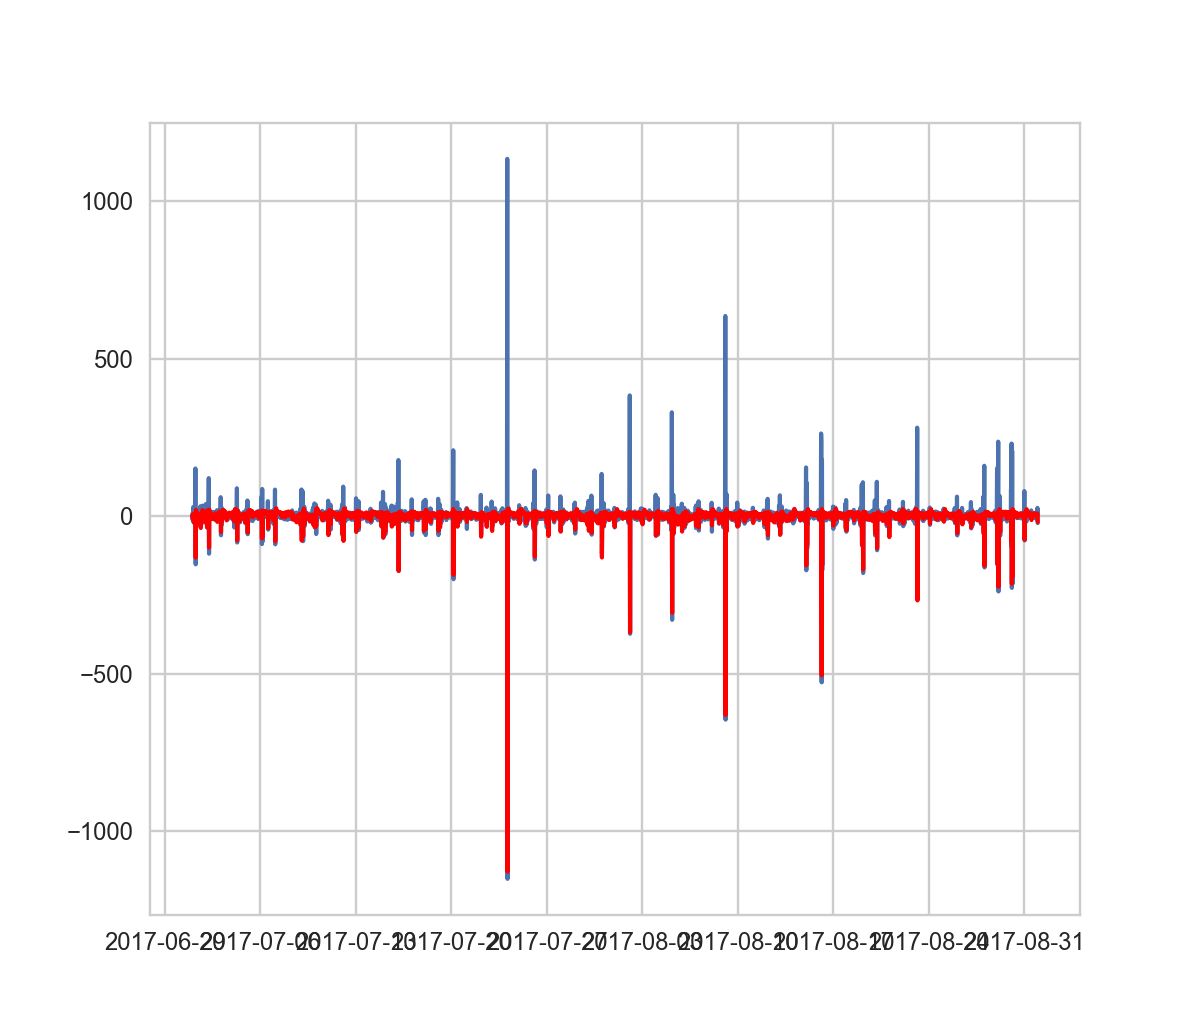

In [233]:
f2, ax2 = plt.subplots(figsize=(7, 6))
ax2.plot(ts_diff)
ax2.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [226]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head(3)

start_time
2017-07-01 00:30:00    0.001951
2017-07-01 01:00:00   -3.634098
2017-07-01 01:30:00    6.015700
Freq: 30T, dtype: float64

In [227]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head(3)

start_time
2017-07-01 00:30:00    0.001951
2017-07-01 01:00:00   -3.632147
2017-07-01 01:30:00    2.383553
Freq: 30T, dtype: float64

In [238]:
predictions_ARIMA = pd.Series(df_halfhour, index=df_halfhour.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA[predictions_ARIMA < 0] = 0
predictions_ARIMA.head(3)

start_time
2017-07-01 00:00:00    17.363636
2017-07-01 00:30:00    24.483433
2017-07-01 01:00:00     9.082139
Freq: 30T, dtype: float64

<IPython.core.display.Javascript object>


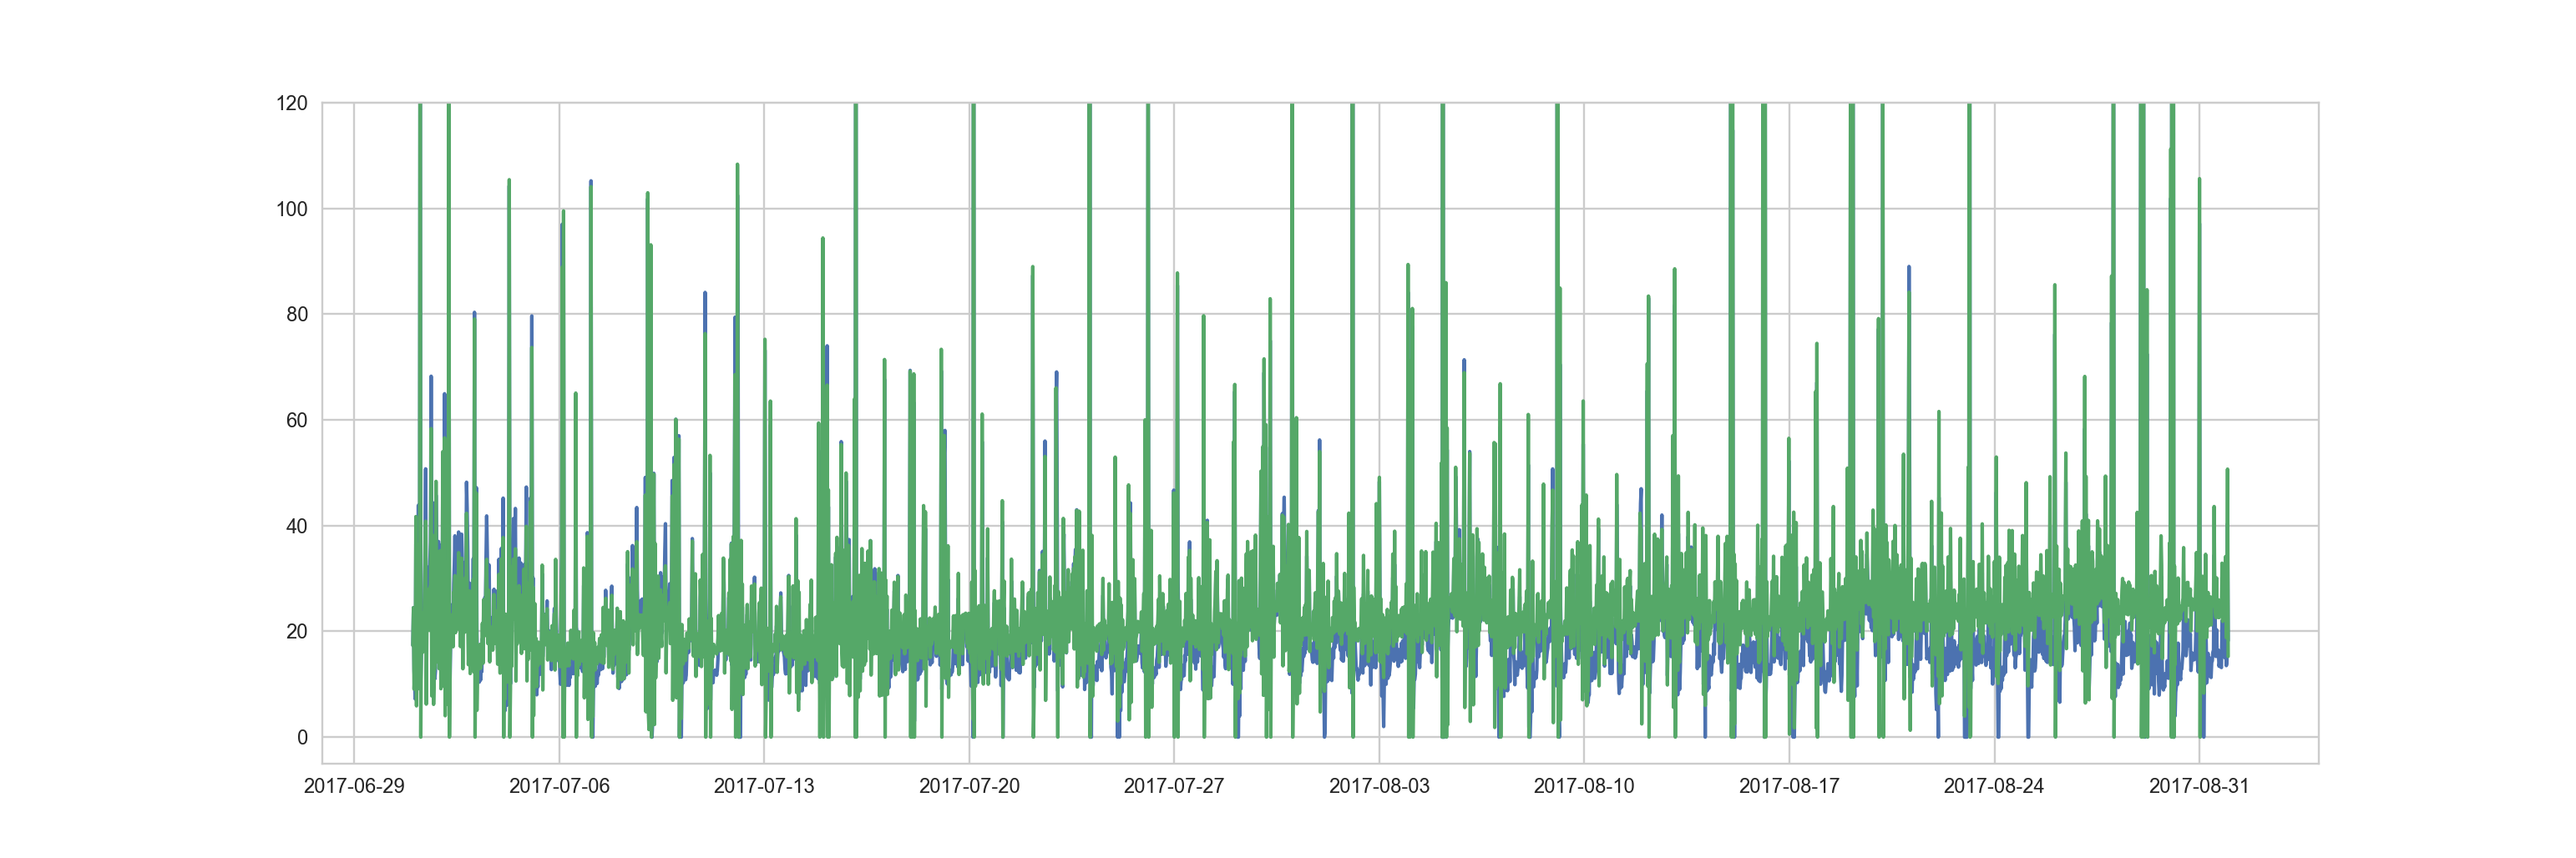

[(-5, 120)]

In [267]:
f3, ax3 = plt.subplots(figsize=(18, 6))
ax3.plot(df_halfhour, label='observation')
ax3.plot(predictions_ARIMA)
ax3.set(ylim=[-5, 120])

<IPython.core.display.Javascript object>


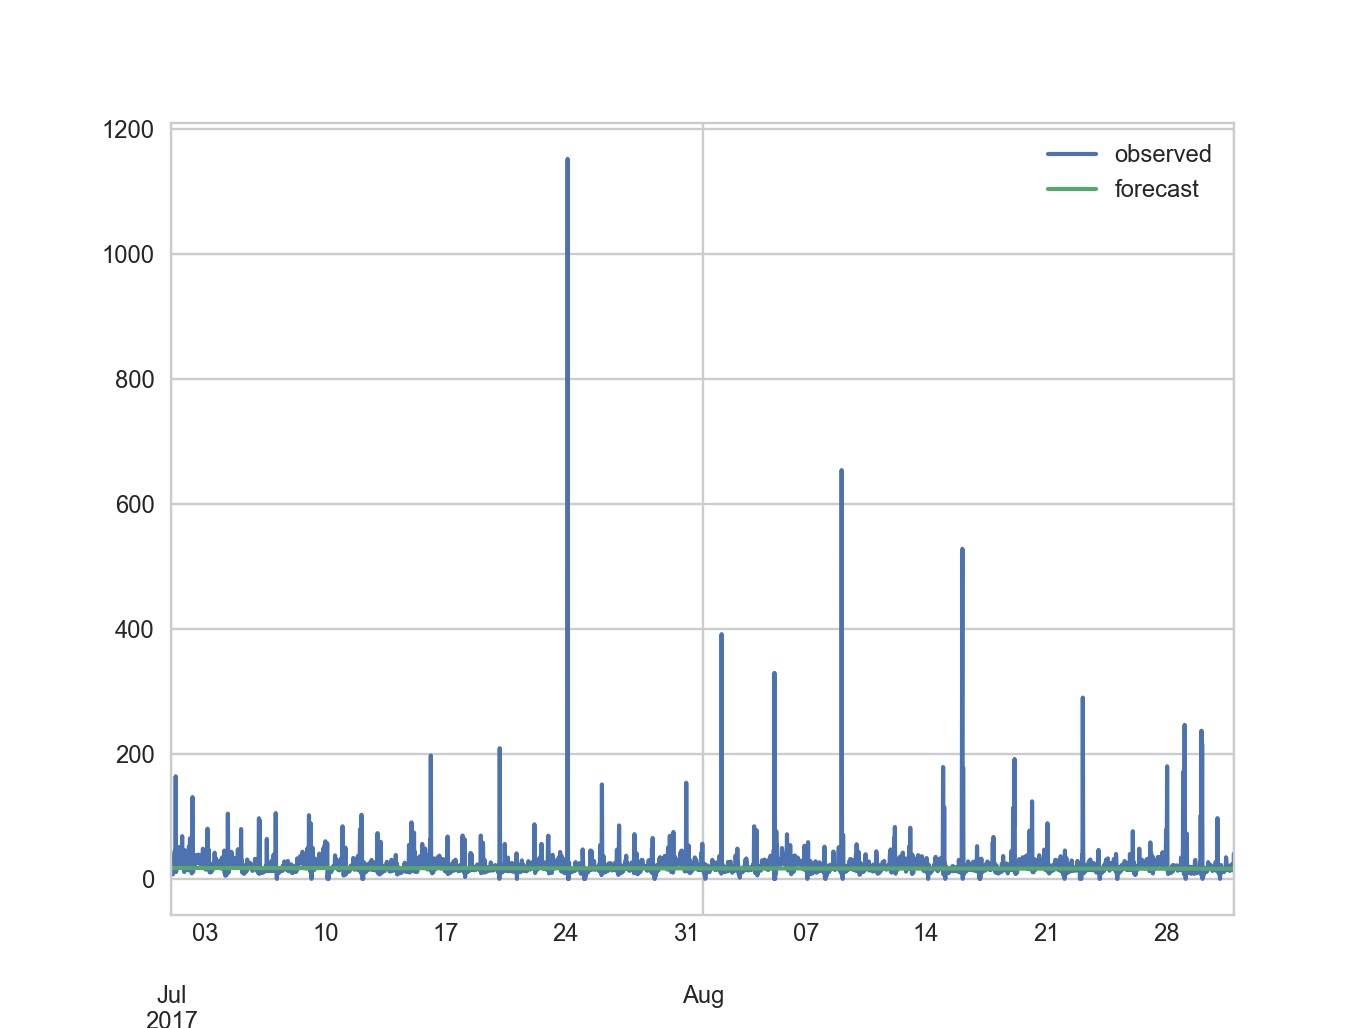

In [268]:
f4, ax4 = plt.subplots(figsize=(8, 6))
# ax4 = df_halfhour['2017-08-20':].plot(label='observed')
ax4 = df_halfhour.loc['2017-07-01':].plot(ax=ax4, label='observed')
ax4 = results_AR.plot_predict('2017-07-01', '2017-08-31', dynamic=True, ax=ax4, plot_insample=False)